# Classification Task for target compound

In [1]:
import torch
import torchdrug as td
from torchdrug import data
import pandas as pd
%matplotlib inline


DATASET_TYPE = "single" #"single"
DATASET_NAME = "chembl29_predicting_target_P14416_P42336"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")

run the next cell if you need to create csv 

In [2]:
# DATA_PATH =  "../data/"+ DATASET_NAME + ".tsv"

# smiles_df = pd.read_csv(DATA_PATH, sep = "\t")
# display(smiles_df.head())

# smiles_df["label"] = pd.factorize(smiles_df["label"])[0]

# if DATASET_TYPE == "dual":

#     smiles_df["target1"] = 0
#     smiles_df["target2"] = 0

#     smiles_df.loc[smiles_df.label == 0, 'target1'] = 1
#     smiles_df.loc[smiles_df.label == 0, 'target2'] = 1

#     smiles_df.loc[smiles_df.label == 1, 'target1'] = 1
#     smiles_df.loc[smiles_df.label == 2, 'target2'] = 1

# smiles_df.to_csv(CSV_DATA_PATH, index = False)


In [3]:
display(smiles_df.head())

,nonstereo_aromatic_smiles,target_pair,label,target1,target2
0,C#CCn1c(=O)c2c(nc3n2CCCN3Cc2ccccc2)n(C)c1=O,P27338_P29274,0,1,1
1,C#CCn1c(=O)c2c(nc3n2CCCN3Cc2ccccc2OC)n(C)c1=O,P27338_P29274,0,1,1
2,CC(=O)c1ccc(C=Cc2cc3c(c(=O)n(C)c(=O)n3C)n2C)cc1,P27338_P29274,0,1,1
3,CC1Oc2ccc(Nc3ncnc4c3oc3ccccc34)cc2NC1=O,P27338_P29274,0,1,1
4,CCCOc1ccc(C=Cc2cc3c(c(=O)n(C)c(=O)n3C)n2C)cc1,P27338_P29274,0,1,1


In [4]:
# ! powershell -command "Set-ExecutionPolicy -ExecutionPolicy AllSigned -Scope CurrentUser"
# ! powershell -command "Import-VisualStudioVars -Architecture x64"
# ! powershell -command "$env:LIB += \";C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\libs\" "

Molecules

torch.Size([24, 69])
torch.Size([52, 19])


C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


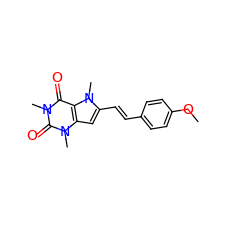

In [5]:
smile = smiles_df.iloc[7]["nonstereo_aromatic_smiles"]
mol = data.Molecule.from_smiles(smile)
mol.visualize()
print(mol.node_feature.shape)
print(mol.edge_feature.shape)

### Graph Operations

C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:858: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


PackedMolecule(batch_size=4, num_nodes=[26, 28, 25, 26], num_edges=[58, 62, 54, 60], num_relation=4, device='cuda:0')


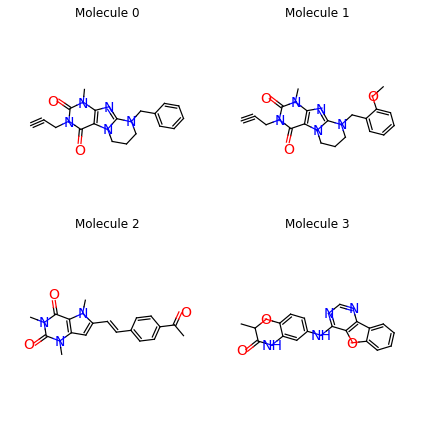

In [6]:
smiles_list = smiles_df.iloc[0:4]["nonstereo_aromatic_smiles"].values
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize()
mols = mols.cuda()
print(mols)

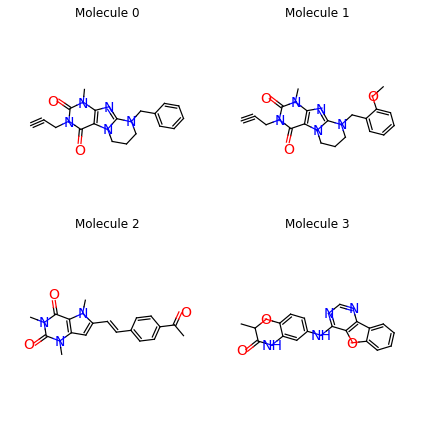

In [7]:
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

## Create Custom MoleculeDataset

In [8]:
import os

from torchdrug import data, utils
from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [9]:
target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]

chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)
chembl_dataset

Loading ../data/chembl29_dt_cpds_P27338_P29274.csv: 100%|██████████| 5701/5701 [00:00<00:00, 44300.34it/s]
Constructing molecules from SMILES: 100%|██████████| 5700/5700 [00:20<00:00, 280.10it/s]


ChEMBL(
  #sample: 5700
  #task: 2
)

In [10]:
chembl_dataset.tasks

['target1', 'target2']

## Define Molecule Classifier

### Load and Prepare Dataset Splits

In [11]:
from torchdrug import datasets

lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(chembl_dataset, lengths)

### Define a Graph Neural Network for Classification
We use a GIN (Graph Isomorphism Network)

In [12]:
from torchdrug import core, models, tasks

model = models.GIN(input_dim=chembl_dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)

In [13]:
task = tasks.PropertyPrediction(model, task=chembl_dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

### Train the Model
Launch twice if it reports compliling errors :-)

In [15]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024, gpus=[0])
solver.train(num_epoch=100)

17:13:37   Preprocess training set
17:13:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:37   Epoch 0 begin
17:13:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:38   binary cross entropy: 7.3006
17:13:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:39   Epoch 0 end
17:13:39   duration: 1.78 secs
17:13:39   speed: 2.81 batch / sec
17:13:39   ETA: 2.94 mins
17:13:39   max GPU memory: 738.8 MiB
17:13:39   ------------------------------
17:13:39   average binary cross entropy: 4.24627
17:13:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:39   Epoch 1 begin
17:13:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:40   Epoch 1 end
17:13:40   duration: 1.00 secs
17:13:40   speed: 5.02 batch / sec
17:13:40   ETA: 2.27 mins
17:13:40   max GPU memory: 746.9 MiB
17:13:40   ------------------------------
17:13:40   average binary cross entropy: 1.96796
17:13:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:40   Epoch 2 begin
17:13:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:13:41   Epoch 2 end
17:13:41   duration: 0.98 secs
17:13:41   speed

Validate model

In [16]:
solver.evaluate("train")
solver.evaluate("valid")
solver.evaluate("test")

17:15:21   Evaluate on train
17:15:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:15:21   auprc [target1]: 0.99998
17:15:21   auprc [target2]: 0.999981
17:15:21   auroc [target1]: 0.999988
17:15:21   auroc [target2]: 0.999965
17:15:21   Evaluate on valid
17:15:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:15:22   auprc [target1]: 0.994305
17:15:22   auprc [target2]: 0.996335
17:15:22   auroc [target1]: 0.995869
17:15:22   auroc [target2]: 0.994529
17:15:22   Evaluate on test
17:15:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:15:22   auprc [target1]: 0.995304
17:15:22   auprc [target2]: 0.998461
17:15:22   auroc [target1]: 0.997508
17:15:22   auroc [target2]: 0.997179


{'auprc [target1]': tensor(0.9953, device='cuda:0'),
 'auprc [target2]': tensor(0.9985, device='cuda:0'),
 'auroc [target1]': tensor(0.9975, device='cuda:0'),
 'auroc [target2]': tensor(0.9972, device='cuda:0')}

save and load

In [ ]:
import json

with open("../models/" + DATASET_NAME + ".json", "w") as fout:
    json.dump(solver.config_dict(), fout)
solver.save("../models/" + DATASET_NAME + ".pth")

16:56:00   Save checkpoint to ../models/chembl29_dt_cpds_Q9Y5N1_P31645.pth


In [ ]:
with open("../models/" + DATASET_NAME + ".json", "r") as fin:
    solver = core.Configurable.load_config_dict(json.load(fin))
solver.load("../models/" + DATASET_NAME + ".pth")

Loading ../data/chembl29_predicting_target_P14416_P42336.csv: 100%|██████████| 7634/7634 [00:00<00:00, 57331.02it/s]
Constructing molecules from SMILES: 100%|██████████| 7633/7633 [00:31<00:00, 239.89it/s]
Loading ../data/chembl29_predicting_target_P14416_P42336.csv: 100%|██████████| 7634/7634 [00:00<00:00, 69109.47it/s]
Constructing molecules from SMILES: 100%|██████████| 7633/7633 [00:31<00:00, 240.03it/s]
Loading ../data/chembl29_predicting_target_P14416_P42336.csv: 100%|██████████| 7634/7634 [00:00<00:00, 60267.12it/s]
Constructing molecules from SMILES: 100%|██████████| 7633/7633 [00:45<00:00, 168.85it/s]

17:00:31   Preprocess training set


17:00:31   Load checkpoint from ../models/chembl29_predicting_target_P14416_P42336.pth


evalutad loaded model

In [ ]:
solver.evaluate("train")

solver.evaluate("valid")

solver.evaluate("test")

17:00:31   Evaluate on train
17:00:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:00:32   auprc [label]: 1
17:00:32   auroc [label]: 1
17:00:32   Evaluate on valid
17:00:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:00:32   auprc [label]: 0.999807
17:00:32   auroc [label]: 0.999833
17:00:32   Evaluate on test
17:00:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:00:33   auprc [label]: 0.999902
17:00:33   auroc [label]: 0.999923


{'auprc [label]': tensor(0.9999, device='cuda:0'),
 'auroc [label]': tensor(0.9999, device='cuda:0')}